# **Ingestion Module Benchmark**

## **Components Tested**
1. **Utils** - Video validation and metadata extraction
2. **Sampler** - Frame sampling strategies (uniform, adaptive, fps, temporal_chunks)
3. **Loader** - GPU/CPU video loading with Decord/OpenCV
4. **Processor** - Batch video processing

## **Metrics Tracked**
- Execution time
- Memory usage
- Throughput (frames/second)

## **Setup**

In [1]:
import sys
import os
import time
import gc
import psutil
import warnings
from pathlib import Path
from typing import List, Dict, Any, Optional
from dataclasses import dataclass, field

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '..')

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

from src.ingestion import (
    RoadVideoLoader,
    FrameSampler,
    sample_video_adaptive,
    sample_video_uniform,
    validate_video,
    get_video_info,
    estimate_memory,
    convert_timestamp_to_frame,
    convert_frame_to_timestamp,
)

from config.settings import get_path_config, get_config

paths = get_path_config()
config = get_config()

print(f"Project root: {paths.project_root}")
print(f"Train videos: {paths.train_videos_dir}")

Project root: D:\Learn\Kaggle Competition\Road-Buddy-Challenge
Train videos: D:\Learn\Kaggle Competition\Road-Buddy-Challenge\data\raw\train\videos


## **Test Videos Selection**

In [3]:
# Find sample videos for testing
train_videos_dir = paths.train_videos_dir

try:
    video_files = list(train_videos_dir.glob("*.mp4"))[:5]
    print(f"Using {len(video_files)} videos for testing and benchmark")
    for v in video_files[:5]:
        print(f"    {v.name}")
except FileNotFoundError:
    print("No videos found in train_videos_dir")

TEST_VIDEOS = [str(v) for v in video_files[:5]]

Using 5 videos for testing and benchmark
    001a9a8b_340_clip_006_0037_0046_Y.mp4
    00af5b3a_305_clip_003_0012_0018_N.mp4
    00b9d4a3_129_clip_002_0009_0015_N.mp4
    00e85ece_240_clip_011_0075_0081_Y.mp4
    01902620_182_clip_014_0097_0105_N.mp4


## **Benchmark Utilities**

In [4]:
@dataclass
class BenchmarkResult:
    """Result from a single benchmark."""
    name: str
    category: str
    execution_time_ms: float = 0.0
    memory_mb: float = 0.0
    throughput: float = 0.0  # items/second
    success: bool = True
    error: str = ""
    details: Dict[str, Any] = field(default_factory=dict)


def get_memory_mb() -> float:
    """Get current process memory in MB."""
    return psutil.Process().memory_info().rss / (1024 * 1024)


def benchmark_function(func, *args, num_runs: int = 3, **kwargs):
    """Benchmark a function with multiple runs.
    
    Returns:
        tuple: (avg_time_ms, result)
    """
    times = []
    result = None
    
    # Warmup
    try:
        _ = func(*args, **kwargs)
    except:
        pass
    
    # Timed runs
    for _ in range(num_runs):
        gc.collect()
        start = time.perf_counter()
        result = func(*args, **kwargs)
        elapsed = (time.perf_counter() - start) * 1000
        times.append(elapsed)
    
    return sum(times) / len(times), result


all_results: List[BenchmarkResult] = []

## **1. Utils Benchmark**

In [5]:
test_video = TEST_VIDEOS[0]
print(f"\nTest video: {Path(test_video).name}")

# 1. validate_video
print("\n1. Testing validate_video()")
time_ms, is_valid = benchmark_function(validate_video, test_video)
all_results.append(BenchmarkResult(
    name="validate_video",
    category="utils",
    execution_time_ms=time_ms,
    details={"is_valid": is_valid}
))
print(f"   Valid: {is_valid}")
print(f"   Time: {time_ms:.2f} ms")

# 2. get_video_info (ffprobe)
print("\n2. Testing get_video_info() with ffprobe")
time_ms, info = benchmark_function(get_video_info, test_video, use_ffprobe=True)
all_results.append(BenchmarkResult(
    name="get_video_info (ffprobe)",
    category="utils",
    execution_time_ms=time_ms,
    details=info
))
print(f"   Time: {time_ms:.2f} ms")
print(f"   Info:")
for k, v in info.items():
    print(f"      {k}: {v}")

# 3. get_video_info (opencv)
print("\n3. Testing get_video_info() with OpenCV")
time_ms, info_cv = benchmark_function(get_video_info, test_video, use_ffprobe=False)
all_results.append(BenchmarkResult(
    name="get_video_info (opencv)",
    category="utils",
    execution_time_ms=time_ms,
    details=info_cv
))
print(f"   Time: {time_ms:.2f} ms")

# 4. estimate_memory
print("\n4. Testing estimate_memory()")
time_ms, mem_est = benchmark_function(estimate_memory, info, num_frames=16)
all_results.append(BenchmarkResult(
    name="estimate_memory",
    category="utils",
    execution_time_ms=time_ms,
    details={"estimated_mb": mem_est}
))
print(f"   Time: {time_ms:.4f} ms")
print(f"   Estimated memory for 16 frames: {mem_est:.2f} MB")

# 5. Timestamp conversions
print("\n5. Testing timestamp conversions")
fps = info.get('fps', 30)
time_ms, frame_idx = benchmark_function(convert_timestamp_to_frame, 2.5, fps, num_runs=100)
print(f"   timestamp_to_frame(2.5s, {fps}fps) = {frame_idx}")
print(f"   Time: {time_ms:.4f} ms")

time_ms, timestamp = benchmark_function(convert_frame_to_timestamp, frame_idx, fps, num_runs=100)
print(f"   frame_to_timestamp({frame_idx}, {fps}fps) = {timestamp:.3f}s")
print(f"   Time: {time_ms:.4f} ms")


Test video: 001a9a8b_340_clip_006_0037_0046_Y.mp4

1. Testing validate_video()


   Valid: True
   Time: 0.19 ms

2. Testing get_video_info() with ffprobe


   Time: 39.57 ms
   Info:
      width: 2560
      height: 1440
      fps: 30.0
      duration: 9.0
      total_frames: 270
      size_mb: 21.08903217315674
      codec: unknown
      format: .mp4

3. Testing get_video_info() with OpenCV
   Time: 30.59 ms

4. Testing estimate_memory()
   Time: 0.0094 ms
   Estimated memory for 16 frames: 42.19 MB

5. Testing timestamp conversions
   timestamp_to_frame(2.5s, 30.0fps) = 75
   Time: 0.0034 ms
   frame_to_timestamp(75, 30.0fps) = 2.500s
   Time: 0.0048 ms


## **2. Sampler Benchmark**

Testing all frame sampling strategies.

In [6]:
# Create sampler
sampler = FrameSampler(seed=42)

# Test parameters
TOTAL_FRAMES = 900  # Simulating a 30-second video at 30fps
VIDEO_FPS = 30.0

print(f"\nTest setup: {TOTAL_FRAMES} frames, {VIDEO_FPS} FPS")
print(f"Video duration: {TOTAL_FRAMES/VIDEO_FPS:.1f} seconds")


Test setup: 900 frames, 30.0 FPS
Video duration: 30.0 seconds


In [7]:
# Test all sampling strategies
sampling_results = []

print("1. Uniform Sampling")

for num_frames in [8, 16, 32]:
    time_ms, indices = benchmark_function(
        sampler.sample_uniform, TOTAL_FRAMES, num_frames, num_runs=10
    )
    sampling_results.append({
        "strategy": "uniform",
        "params": f"n={num_frames}",
        "output_frames": len(indices),
        "time_ms": time_ms,
        "indices_sample": indices[:5]
    })
    print(f"   n={num_frames}: {len(indices)} frames in {time_ms:.3f}ms")
    print(f"      Sample indices: {indices[:5]}")

1. Uniform Sampling
   n=8: 8 frames in 0.096ms
      Sample indices: [0, 128, 256, 385, 513]
   n=16: 16 frames in 0.105ms
      Sample indices: [0, 59, 119, 179, 239]
   n=32: 32 frames in 0.122ms
      Sample indices: [0, 29, 58, 87, 116]


In [8]:
print("2. Adaptive Sampling")

for min_f, max_f, fps_rate in [(4, 32, 0.5), (8, 64, 1.0), (16, 128, 2.0)]:
    time_ms, indices = benchmark_function(
        sampler.sample_adaptive, TOTAL_FRAMES, VIDEO_FPS, 
        min_f, max_f, fps_rate, num_runs=10
    )
    sampling_results.append({
        "strategy": "adaptive",
        "params": f"min={min_f},max={max_f},fps={fps_rate}",
        "output_frames": len(indices),
        "time_ms": time_ms,
        "indices_sample": indices[:5]
    })
    print(f"   min={min_f},max={max_f},fps={fps_rate}: {len(indices)} frames in {time_ms:.3f}ms")

2. Adaptive Sampling
   min=4,max=32,fps=0.5: 15 frames in 0.097ms
   min=8,max=64,fps=1.0: 30 frames in 0.095ms
   min=16,max=128,fps=2.0: 60 frames in 0.101ms


In [9]:
print("3. FPS-based Sampling")

for target_fps in [0.5, 1.0, 2.0, 5.0]:
    time_ms, indices = benchmark_function(
        sampler.sample_fps, TOTAL_FRAMES, VIDEO_FPS, target_fps, num_runs=10
    )
    sampling_results.append({
        "strategy": "fps",
        "params": f"target={target_fps}",
        "output_frames": len(indices),
        "time_ms": time_ms,
        "indices_sample": indices[:5] if indices else []
    })
    print(f"   target_fps={target_fps}: {len(indices)} frames in {time_ms:.3f}ms")

3. FPS-based Sampling
   target_fps=0.5: 15 frames in 0.026ms
   target_fps=1.0: 30 frames in 0.015ms
   target_fps=2.0: 60 frames in 0.018ms
   target_fps=5.0: 150 frames in 0.022ms


In [10]:
print("4. Temporal Chunks Sampling")

for num_chunks, frames_per_chunk in [(4, 2), (8, 2), (4, 4), (8, 4)]:
    time_ms, indices = benchmark_function(
        sampler.sample_temporal_chunks, TOTAL_FRAMES, num_chunks, frames_per_chunk, num_runs=10
    )
    sampling_results.append({
        "strategy": "temporal_chunks",
        "params": f"chunks={num_chunks},per_chunk={frames_per_chunk}",
        "output_frames": len(indices),
        "time_ms": time_ms,
        "indices_sample": indices[:5]
    })
    print(f"   chunks={num_chunks}, per_chunk={frames_per_chunk}: {len(indices)} frames in {time_ms:.3f}ms")

4. Temporal Chunks Sampling
   chunks=4, per_chunk=2: 8 frames in 0.120ms
   chunks=8, per_chunk=2: 16 frames in 0.168ms
   chunks=4, per_chunk=4: 16 frames in 0.146ms
   chunks=8, per_chunk=4: 32 frames in 0.166ms


In [11]:
df_sampler = pd.DataFrame(sampling_results)
display(df_sampler[['strategy', 'params', 'output_frames', 'time_ms']])

# Add to all_results
for r in sampling_results:
    all_results.append(BenchmarkResult(
        name=f"sample_{r['strategy']} ({r['params']})",
        category="sampler",
        execution_time_ms=r['time_ms'],
        details=r
    ))

,strategy,params,output_frames,time_ms
0,uniform,n=8,8,0.09616
1,uniform,n=16,16,0.10488
2,uniform,n=32,32,0.12235
3,adaptive,"min=4,max=32,fps=0.5",15,0.09747
4,adaptive,"min=8,max=64,fps=1.0",30,0.09537
5,adaptive,"min=16,max=128,fps=2.0",60,0.10139
6,fps,target=0.5,15,0.02572
7,fps,target=1.0,30,0.01530
8,fps,target=2.0,60,0.01801
9,fps,target=5.0,150,0.02175


## **3. Loader Benchmark**

Testing video loading with different backends and sampling methods.

In [12]:
test_video = TEST_VIDEOS[0]
print(f"\nTest video: {Path(test_video).name}")

video_info = get_video_info(test_video)
print(f"Video info: {video_info['width']}x{video_info['height']}, "
        f"{video_info['fps']:.1f}fps, {video_info['duration']:.1f}s")


Test video: 001a9a8b_340_clip_006_0037_0046_Y.mp4
Video info: 2560x1440, 30.0fps, 9.0s


In [23]:
# Test different loading configurations
loader_results = []
    
@dataclass
class VideoConfig:
    video_path: str
    device: str = "cpu"
    ctx_id: int = 0
    batch_size: int = 8
    num_threads: int = 0
    width: int = -1
    height: int = -1

test_video = TEST_VIDEOS[0]

# 1. CPU Loading
print("1. CPU Loading (Decord/OpenCV)")

cfg = VideoConfig(video_path=test_video, device="cpu")

gc.collect()
mem_before = get_memory_mb()
start = time.perf_counter()

loader = RoadVideoLoader(cfg)
init_time = (time.perf_counter() - start) * 1000

print(f"   Init time: {init_time:.2f} ms")
print(f"   Total frames: {len(loader)}")
print(f"   Metadata: {loader.get_metadata()}")

1. CPU Loading (Decord/OpenCV)
   Init time: 343.42 ms
   Total frames: 270
   Metadata: {'backend': 'decord', 'fps': 30.0, 'total_frames': 270, 'duration': 9.0, 'width': 2560, 'height': 1440, 'path': 'D:\\Learn\\Kaggle Competition\\Road-Buddy-Challenge\\data\\raw\\train\\videos\\001a9a8b_340_clip_006_0037_0046_Y.mp4', 'size_mb': 21.08903217315674}


In [ ]:
# Test sampling methods
print("2. Testing Sampling Methods")

# 2a. Uniform sampling
print("\n  a) Uniform Sampling (8 frames)")
gc.collect()
mem_before = get_memory_mb()
start = time.perf_counter()
frames = loader.sample_uniform(8)
elapsed = (time.perf_counter() - start) * 1000
mem_after = get_memory_mb()

loader_results.append({
    "method": "sample_uniform",
    "params": "n=8",
    "time_ms": elapsed,
    "memory_mb": mem_after - mem_before,
    "output_shape": str(frames.shape) if frames is not None else "None"
})
print(f"     Output shape: {frames.shape}")
print(f"     Time: {elapsed:.2f} ms")
print(f"     Memory: {max(0, mem_after - mem_before):.1f} MB")

# 2b. FPS sampling
print("\n  b) FPS Sampling (1 fps)")
gc.collect()
start = time.perf_counter()
frames = loader.sample_fps(1.0)
elapsed = (time.perf_counter() - start) * 1000

loader_results.append({
    "method": "sample_fps",
    "params": "fps=1.0",
    "time_ms": elapsed,
    "output_shape": str(frames.shape) if frames is not None else "None"
})
print(f"     Output shape: {frames.shape}")
print(f"     Time: {elapsed:.2f} ms")

# 2c. Adaptive sampling
print("\n  c) Adaptive Sampling (8-32 frames)")
gc.collect()
start = time.perf_counter()
frames = loader.sample_adaptive(min_frames=8, max_frames=32)
elapsed = (time.perf_counter() - start) * 1000

loader_results.append({
    "method": "sample_adaptive",
    "params": "min=8,max=32",
    "time_ms": elapsed,
    "output_shape": str(frames.shape) if frames is not None else "None"
})
print(f"     Output shape: {frames.shape}")
print(f"     Time: {elapsed:.2f} ms")

# 2d. Temporal chunks
print("\n  d) Temporal Chunks (4 chunks x 2 frames)")
gc.collect()
start = time.perf_counter()
frames = loader.sample_temporal_chunks(num_chunks=4, frames_per_chunk=2)
elapsed = (time.perf_counter() - start) * 1000

loader_results.append({
    "method": "sample_temporal_chunks",
    "params": "chunks=4,per=2",
    "time_ms": elapsed,
    "output_shape": str(frames.shape) if frames is not None else "None"
})
print(f"     Output shape: {frames.shape}")
print(f"     Time: {elapsed:.2f} ms")

2. Testing Sampling Methods

  a) Uniform Sampling (8 frames)
     Output shape: torch.Size([8, 3, 1440, 2560])
     Time: 1492.58 ms
     Memory: 112.3 MB

  b) FPS Sampling (1 fps)
     Output shape: torch.Size([9, 3, 1440, 2560])
     Time: 1298.39 ms

  c) Adaptive Sampling (8-32 frames)
     Output shape: torch.Size([8, 3, 1440, 2560])
     Time: 1453.06 ms

  d) Temporal Chunks (4 chunks x 2 frames)
     Output shape: torch.Size([8, 3, 1440, 2560])
     Time: 1538.45 ms


In [26]:
df_loader = pd.DataFrame(loader_results)
display(df_loader)

for r in loader_results:
    all_results.append(BenchmarkResult(
        name=f"loader.{r['method']} ({r['params']})",
        category="loader",
        execution_time_ms=r['time_ms'],
        details=r
    ))

,method,params,time_ms,memory_mb,output_shape
0,sample_uniform,n=8,1492.5796,112.289062,"torch.Size([8, 3, 1440, 2560])"
1,sample_fps,fps=1.0,1298.3889,NaN,"torch.Size([9, 3, 1440, 2560])"
2,sample_adaptive,"min=8,max=32",1453.0612,NaN,"torch.Size([8, 3, 1440, 2560])"
3,sample_temporal_chunks,"chunks=4,per=2",1538.4507,NaN,"torch.Size([8, 3, 1440, 2560])"


## **4. Multi-Video Throughput Test**

In [30]:
multi_video_results = []

for video_path in TEST_VIDEOS[:5]:
    video_name = Path(video_path).name
    
    try:
        # Time the full pipeline
        gc.collect()
        start = time.perf_counter()
        
        cfg = VideoConfig(video_path=video_path, device="cpu")
        loader = RoadVideoLoader(cfg)
        frames = loader.sample_uniform(8)
        
        elapsed = (time.perf_counter() - start) * 1000
        
        throughput = (8 / elapsed) * 1000  # frames per second
        
        multi_video_results.append({
            "video": video_name[:30],
            "total_frames": len(loader),
            "sampled_frames": 8,
            "total_time_ms": elapsed,
            "throughput_fps": throughput
        })
        
        print(f"{video_name[:30]}: {elapsed:.1f}ms ({throughput:.1f} fps)")
        
    except Exception as e:
        print(f"{video_name}: {e}")

if multi_video_results:
    df_multi = pd.DataFrame(multi_video_results)
    print(f"\nAverage throughput: {df_multi['throughput_fps'].mean():.1f} fps")
    print(f"Average time: {df_multi['total_time_ms'].mean():.1f} ms")

001a9a8b_340_clip_006_0037_004: 1335.9ms (6.0 fps)
00af5b3a_305_clip_003_0012_001: 905.3ms (8.8 fps)
00b9d4a3_129_clip_002_0009_001: 1032.6ms (7.7 fps)
00e85ece_240_clip_011_0075_008: 446.8ms (17.9 fps)
01902620_182_clip_014_0097_010: 481.3ms (16.6 fps)

Average throughput: 11.4 fps
Average time: 840.4 ms


## **5. Results Visualization**

In [17]:
# Create summary dataframe
summary_data = []
for r in all_results:
    summary_data.append({
        "Category": r.category,
        "Function": r.name,
        "Time (ms)": r.execution_time_ms,
        "Memory (MB)": r.memory_mb,
        "Success": r.success
    })

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("COMPLETE BENCHMARK SUMMARY")
print("="*80)
display(df_summary)


COMPLETE BENCHMARK SUMMARY


,Category,Function,Time (ms),Memory (MB),Success
0,utils,validate_video,0.188567,0.0,True
1,utils,get_video_info (ffprobe),39.567200,0.0,True
2,utils,get_video_info (opencv),30.591233,0.0,True
3,utils,estimate_memory,0.009367,0.0,True
4,sampler,sample_uniform (n=8),0.096160,0.0,True
5,sampler,sample_uniform (n=16),0.104880,0.0,True
6,sampler,sample_uniform (n=32),0.122350,0.0,True
7,sampler,"sample_adaptive (min=4,max=32,fps=0.5)",0.097470,0.0,True
8,sampler,"sample_adaptive (min=8,max=64,fps=1.0)",0.095370,0.0,True
9,sampler,"sample_adaptive (min=16,max=128,fps=2.0)",0.101390,0.0,True


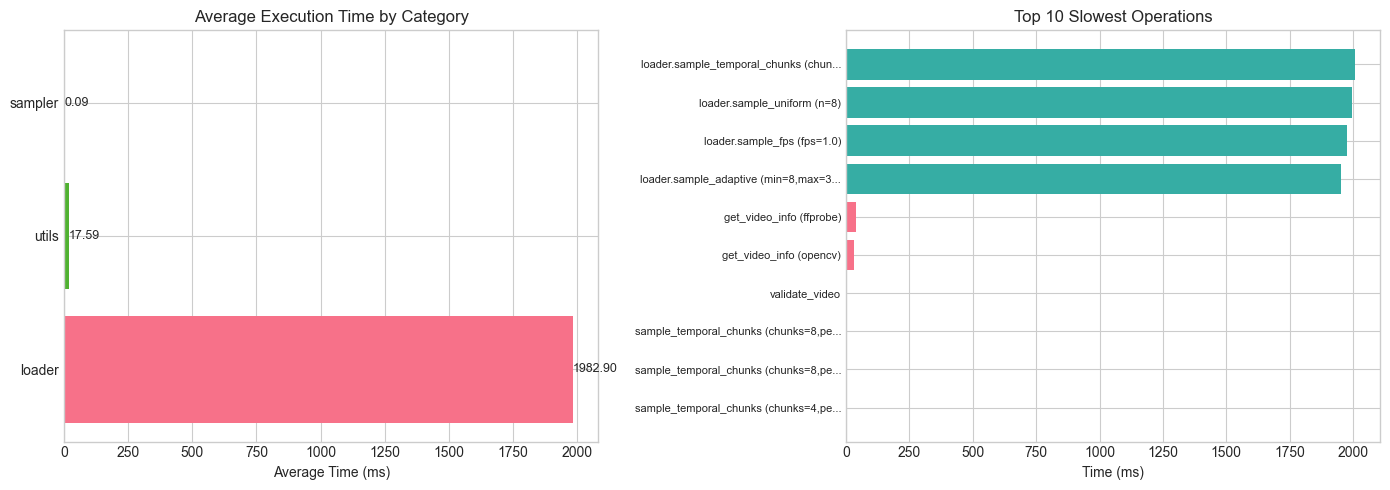

In [31]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Execution time by category
ax1 = axes[0]
category_times = df_summary.groupby('Category')['Time (ms)'].mean().sort_values(ascending=False)
colors = sns.color_palette('husl', len(category_times))
bars = ax1.barh(category_times.index, category_times.values, color=colors)
ax1.set_xlabel('Average Time (ms)')
ax1.set_title('Average Execution Time by Category')
for bar, val in zip(bars, category_times.values):
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{val:.2f}', va='center', fontsize=9)

# 2. Top 10 slowest functions
ax2 = axes[1]
top_slow = df_summary.nlargest(10, 'Time (ms)')
colors = [sns.color_palette('husl', 4)[['utils', 'sampler', 'loader', 'processor'].index(c)] 
          if c in ['utils', 'sampler', 'loader', 'processor'] else 'gray' 
          for c in top_slow['Category']]
bars = ax2.barh(range(len(top_slow)), top_slow['Time (ms)'].values, color=colors)
ax2.set_yticks(range(len(top_slow)))
ax2.set_yticklabels([n[:35] + '...' if len(n) > 35 else n for n in top_slow['Function']], fontsize=8)
ax2.set_xlabel('Time (ms)')
ax2.set_title('Top 10 Slowest Operations')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('./outputs/ingestion_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

In [35]:
# Export to CSV
df_summary.to_csv('./outputs/ingestion_benchmark.csv', index=False)

print(f"\nTotal functions tested: {len(all_results)}")
print(f"Categories: {df_summary['Category'].unique().tolist()}")
print(f"\nFastest operation: {df_summary.loc[df_summary['Time (ms)'].idxmin(), 'Function']}")
print(f"Slowest operation: {df_summary.loc[df_summary['Time (ms)'].idxmax(), 'Function']}")


Total functions tested: 30
Categories: ['utils', 'sampler', 'loader']

Fastest operation: estimate_memory
Slowest operation: loader.sample_temporal_chunks (chunks=4,per=2)
